In [7]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from nam.wrapper import NAMClassifier
import sklearn.metrics as sk_metrics
import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
#load data
X = pd.read_csv('data/data_preprocessed.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('data/test_data_preprocessed.csv').drop('Unnamed: 0', axis=1)
y = pd.read_csv('data/outcome.csv')['HeartDisease']
y_test = pd.read_csv('data/outcome_test.csv')['HeartDisease']

In [26]:
random_state = 2016
NUMBER_OF_LEARNERS = 5
model = NAMClassifier(
            num_epochs=50,
            num_learners=NUMBER_OF_LEARNERS,
            metric='auroc',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=10,
            random_state=random_state
        )

model.fit(X, y)

In [4]:
X.columns

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak',
       'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'FastingBS_0', 'FastingBS_1', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N',
       'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

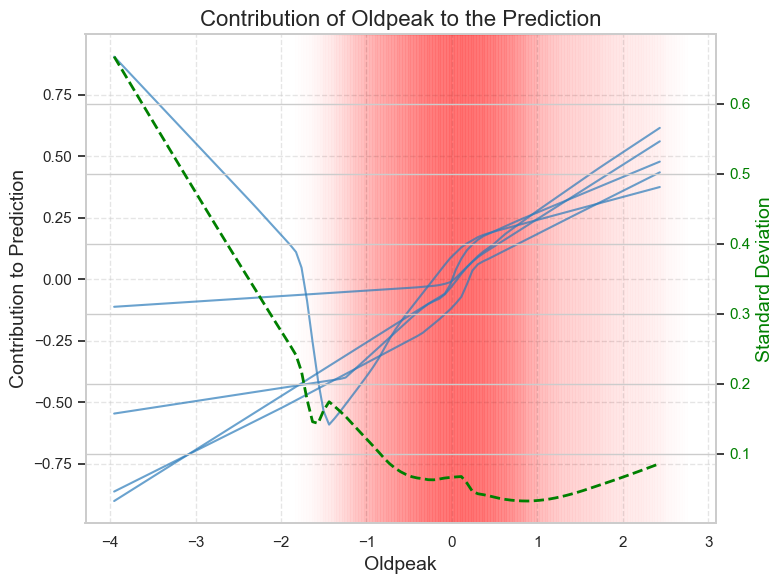

In [27]:
sns.set(style="whitegrid", palette="muted")

feature_names = X_test.columns
for i, feature_name in enumerate(feature_names):
    if feature_name == 'Oldpeak':
        fig, ax1 = plt.subplots(figsize=(8, 6))

        # Compute KDE of the feature to get distribution
        values = X_test[feature_name].dropna().values
        kde = gaussian_kde(values)
        xs = torch.linspace(values.min(), values.max(), 200)
        density = kde(xs.numpy())

        # Normalize for shading
        density_norm = density / density.max()

        # Add vertical background shading
        bar_width = (xs[1] - xs[0]).item() * 10
        for x_val, shade in zip(xs, density_norm):
            ax1.axvspan(x_val.item(), x_val.item() + bar_width, color='red', alpha=0.07 * shade)

        # Plot NAM feature contributions
        xs_plot = torch.linspace(values.min(), values.max(), 100)
        all_ys = []
        for learner_ind in range(NUMBER_OF_LEARNERS):
            ys = model.models[learner_ind].feature_nns[i](xs_plot.unsqueeze(1)).detach().numpy().reshape(xs_plot.shape)
            all_ys.append(ys)
            ax1.plot(xs_plot, ys, c=sns.color_palette("Blues")[4], alpha=0.7)

        ax1.set_title(f"Contribution of {feature_name} to the Prediction", fontsize=16)
        ax1.set_xlabel(f"{feature_name}", fontsize=14)
        ax1.set_ylabel("Contribution to Prediction", fontsize=14)
        ax1.grid(True, linestyle="--", alpha=0.5)

        # Compute standard deviation across learners
        all_ys = np.stack(all_ys)
        std_ys = np.std(all_ys, axis=0)

        # Create a secondary y-axis for the standard deviation
        ax2 = ax1.twinx()
        ax2.plot(xs_plot, std_ys, color='green', linestyle='--', linewidth=2, label='Std. Dev. Across Learners')
        ax2.set_ylabel("Standard Deviation", fontsize=14, color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        fig.tight_layout()
        plt.show()


In [41]:
print('----[TRAIN RESULTS]----')
pred = model.predict_proba(X)
print('F1 score:', sk_metrics.f1_score(y, pred > 0.5))
print('ROC AUC:', sk_metrics.roc_auc_score(y, pred))
print('----[TEST RESULTS]----')
pred = model.predict_proba(X_test)
print('F1 score:', sk_metrics.f1_score(y_test, pred > 0.5))
print('ROC AUC:', sk_metrics.roc_auc_score(y_test, pred))

----[TRAIN RESULTS]----
F1 score: 0.8946078431372548
ROC AUC: 0.9385842905001197
----[TEST RESULTS]----
F1 score: 0.8771929824561402
ROC AUC: 0.9031941031941032


In [15]:
feature_names = X.columns

In [36]:
model.num_learners

5